# Image classification and segmentation

- when it comes to images, a lot has been achieved in the last few year
- we can train state-of-the-art model at home for most of the problems related to images

- Image is nothing but matrix of numbers
- Computer can't see the images as humans do
- a grayscale image is a 2d matrix with values ranging from 0 to 255. 0 is black, 1 is white
- rgb images, three matrices in place of one

- 'ravel' is flatten the matrix
    - row 1st then row 2nd

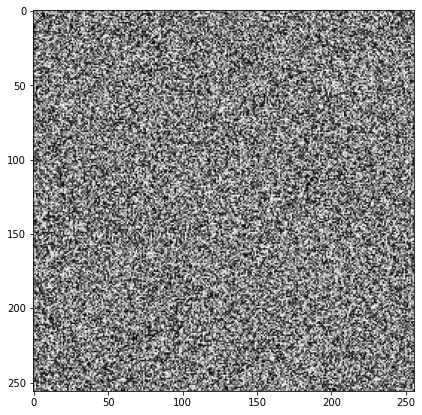

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# generate random array with values from 0 to 255
random_image = np.random.randint(0, 256, (256,256))
plt.figure(figsize=(7,7))
plt.imshow(random_image, cmap="gray", vmin=0, vmax=255)
plt.show()

# siim classification

- The original problem is for segmentation
- we will use classifier here for leraning here


In [2]:
import os
import pandas as pd
train = pd.read_csv("../input/siim_png/train-rle.csv")
train.columns = ['ImageId', 'EncodedPixels']
print(train.columns)
train['target'] = 1
train.loc[train['EncodedPixels'] == "-1", 'target'] = 0
print(train.shape)
a = train.ImageId.values
train_ = os.listdir("../input/siim_png/train_png/")
train_ = [x.replace('.png','') for x in train_]
train = train[train['ImageId'].isin(train_)].reset_index(drop=True)
print(train.shape)
train = train.groupby('ImageId').head(1).reset_index(drop=True)
print(train.shape)
train.to_csv("../input/siim_png/train.csv")
train.head()

Index(['ImageId', 'EncodedPixels'], dtype='object')
(12954, 3)
(11582, 3)
(10675, 3)


,ImageId,EncodedPixels,target
0,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1
1,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0
2,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1
3,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1
4,1.2.276.0.7230010.3.1.4.8323329.11444.15178752...,-1,0


# Image classifier using random forest


In [3]:
import os
print(os.getcwd())
import pandas as pd
# !pip install pillow
# import PIL
# !pip install tqdm
from PIL import Image
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from tqdm.notebook import tqdm

/Users/Paritosh_Gupta/Desktop/aamlp/notebooks


## SIIM Classification using Random Forest

In [ ]:
def create_dataset(training_df, image_dir):
    """
    This function takes the training dataframe and returns training array and labels
    :param training_df: dataframe with ImageId, Target columns
    :param image_dir: location of images(folder), string
    : return X, y (training array with features and labels)
    """
    # create empty list to store image vectors
    images = []
    # create empty list to store targets
    targets = []
    
    # loop. over the dataframe
    for index, row in tqdm(training_df.iterrows(), total=len(training_df), desc="processing images"):
        
        # get image id
        image_id = row["ImageId"]
        
        # create image path
        image_path = os.path.join(image_dir, image_id)
        # open image using PIL
        image = Image.open(image_path + ".png")
        
        # resize image to 256 * 256. we use bilinear resampling
        image = image.resize((256, 256), resample=Image.BILINEAR)
        
        # convert image to array
        image = np.array(image)
        
        # ravel
        image = image.ravel()
        
        # append images and targets lists
        images.append(image)
        targets.append(int(row["target"]))
        
    # convert list of list of images to numpy array
    images = np.array(images)
    
    print(f"Size of images array --> {images.shape}")
    
    return images, targets


if __name__ == "__main__":
    
    csv_path = "../input/siim_png/train.csv"
    image_path = "../input/siim_png/train_png/"
    
    # read csv with imageid and target column
    df = pd.read_csv(csv_path)
    df["kfold"] = -1

    # the next step is to randomize the rows of data
    df = df.sample(frac=1).reset_index(drop=True)
    
    # fetch labels
    y = df.target.values
    
    # initiate the kfold class from model selection
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    for f, (t_, v_) in enumerate(kf.split(X =df, y=y)):
        df.loc[v_, 'kfold'] = f
        
    # go over each fold
    for fold_ in range(5):
        # temporary df
        train_df = df[df.kfold != fold_].reset_index(drop=True)
        valid_df = df[df.kfold == fold_].reset_index(drop=True)
        
        # create train and test dataset
        # udf call
        xtrain, ytrain = create_dataset(train_df, image_path)
        
        # udf call
        xvalid, yvalid = create_dataset(valid_df, image_path)
        
        # fit random forest classifier
        clf = ensemble.RandomForestClassifier(n_jobs=-1)
        clf.fit(xtrain, ytrain)
        
        # predict
        preds = clf.predict_proba(xvalid)[:, 1]
        
        print(f" Fold - {fold_}, AUC = {metrics.roc_auc_score(yvalid, preds)}")
              
        
    
    
    


Size of images array --> (8540, 65536)



Size of images array --> (2135, 65536)
 Fold - 0, AUC = 0.7683792010145846



Size of images array --> (8540, 65536)



Size of images array --> (2135, 65536)
 Fold - 1, AUC = 0.7243036455088364



Size of images array --> (8540, 65536)



Size of images array --> (2135, 65536)
 Fold - 2, AUC = 0.7054562331261618



Size of images array --> (8540, 65536)



Size of images array --> (2135, 65536)
 Fold - 3, AUC = 0.7152373607670915



Size of images array --> (8540, 65536)



Size of images array --> (2135, 65536)


In [ ]:
(0.768 + 0.7243036455088364 + 0.7054562331261618 + 0.7152373607670915 + )/5